In [1]:
import pandas as pd

In [2]:
!pip install Lifetimes

  Created wheel for autograd: filename=autograd-1.3-py3-none-any.whl size=47988 sha256=8bb4fb6b35b284166d56c94fb5aafcf680184415e5c4b194af5824c640891fd8
  Stored in directory: c:\users\zywon\appdata\local\pip\cache\wheels\ef\32\31\0e87227cd0ca1d99ad51fbe4b54c6fa02afccf7e483d045e04
Successfully built autograd


In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity

In [4]:
transactions = pd.read_csv('transactions_train.csv')

In [5]:
articles = pd.read_csv('articles.csv')

In [6]:
view = pd.merge(left=transactions, right=articles, how='left', left_on='article_id', right_on='article_id')

In [7]:
view.head(5)

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,541518,Rae Push (Melbourne) 2p,306,Bra,Underwear,...,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up bras with underwired, moulded, pa..."
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,505221,Inca Jumper,252,Sweater,Garment Upper body,...,Tops Knitwear DS,D,Divided,2,Divided,58,Divided Selected,1003,Knitwear,Jumper in rib-knit cotton with hard-worn detai...
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,...,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,...,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...


In [8]:
view1 = view.groupby(["product_type_name", "department_name"]).agg({'price': 'mean'}).reset_index()

In [12]:
view1.head(5)

,product_type_name,department_name,price
0,Accessories set,Baby Toys/Acc,0.021262
1,Accessories set,Boys Small Acc & Bags,0.009729
2,Accessories set,Kids Girl Big Acc,0.022017
3,Alice band,Girls Small Acc/Bags,0.008016
4,Alice band,Hair Accessories,0.010388


In [13]:
# Baby toys in H&M US Website --> 20+ USD

In [5]:
data.head(5)

In [14]:
transactions.describe()

,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e-02,1.704028e+00
std,1.334480e+08,1.918113e-02,4.564786e-01
min,1.087750e+08,1.694915e-05,1.000000e+00
25%,6.328030e+08,1.581356e-02,1.000000e+00
50%,7.145820e+08,2.540678e-02,2.000000e+00
75%,7.865240e+08,3.388136e-02,2.000000e+00
max,9.562170e+08,5.915254e-01,2.000000e+00


In [15]:
df = transactions.copy()

In [16]:
# Assumption scale by 1000
df['price'] = df['price'] * 1000

In [16]:
df.describe()

In [17]:
df.describe()

,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e+01,1.704028e+00
std,1.334480e+08,1.918113e+01,4.564786e-01
min,1.087750e+08,1.694915e-02,1.000000e+00
25%,6.328030e+08,1.581356e+01,1.000000e+00
50%,7.145820e+08,2.540678e+01,2.000000e+00
75%,7.865240e+08,3.388136e+01,2.000000e+00
max,9.562170e+08,5.915254e+02,2.000000e+00


In [18]:
df.drop(["sales_channel_id"], axis = 1, inplace=True)

In [19]:
data_grp = df.groupby(["t_dat", "customer_id"]).agg({'article_id':'count', 'price': 'sum'}).reset_index()

In [20]:
data_grp.describe()

,article_id,price
count,9.080179e+06,9.080179e+06
mean,3.500848e+00,9.742605e+01
std,3.619618e+00,1.128216e+02
min,1.000000e+00,1.694915e-02
25%,1.000000e+00,3.388136e+01
50%,2.000000e+00,6.098305e+01
75%,4.000000e+00,1.185593e+02
max,5.700000e+02,2.247976e+04


CLV

4.1 Definitions
* Recency: the number of time periods between a customer’s first and last (latest) transactions
* Frequency: the number of time periods, after the initial purchase, when the customer buys again
* Monetary Value: the average value of the customer’s transactions (revenues or profit per transaction)

Additionally,
* Customer age T: the number of time periods since the customer’s first purchase

In [24]:
data_grp['t_dat'] = pd.to_datetime(data_grp['t_dat'])

In [26]:
# train/test split (calibration/holdout)
t_holdout = 240                                         # days to reserve for holdout period

max_date = data_grp["t_dat"].max()                     # end date of observations
print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
print("end of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = data_grp, 
        customer_id_col = "customer_id", 
        datetime_col = "t_dat",
        monetary_value_col = "price", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date, 
        freq = "D")  

print("customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

end of observations: 2020-09-22 00:00:00
end of calibration period: 2020-01-26 00:00:00
customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,7,336,395,56,2,72,240
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,19,491,492,110,3,129,240
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,2,162,493,32,4,140,240
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0,0,231,0,0,0,240
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,3,362,471,49,2,128,240
...,...,...,...,...,...,...,...
ffffaff3905b803d1c7e153a1378a5151e1f34f236ba5451afc7cf3f699c5690,0,0,457,0,0,0,240
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,4,245,298,41,6,102,240
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,11,486,488,105,7,84,240


5.1 BG/NBD Concept
In non-contractual business settings, the purchase behavior of customers does not follow a deterministic trend. Both demand levels and churn rates are random variables. A distributional model like BG/NBD describes the random processes that influence the customer behavior, individually and in aggregate.
The method relies on four distributional assumptions to model the uncertainties:
* The number of orders a customer will place in a time period follows a Poisson distribution with transaction rate lambda. This Poisson count distribution is equivalent to the assumption that the time between transactions follows an exponential distribution with the same transaction rate lambda.
* The demand varies independently between customers: heterogeneity in lambda. The variation in lambda is a random variable that follows a Gamma distribution with shape parameter r and scale alpha.
* After any purchase, a customer may become inactive with probability p and turns away from the business. The churn risk follows a Geometric distribution.
* The churn risk varies independently between customers: heterogeneity in p. The variation of the churn or dropout probability p is a random variable that follows a Beta distribution.

In [27]:
# training: BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)

Optimization terminated successfully.
         Current function value: -5.726222
         Iterations: 25
         Function evaluations: 27
         Gradient evaluations: 27


<lifetimes.BetaGeoFitter: fitted with 1137749 subjects, a: 0.10, alpha: 44.90, b: 1.54, r: 0.61>

<Figure size 864x864 with 0 Axes>

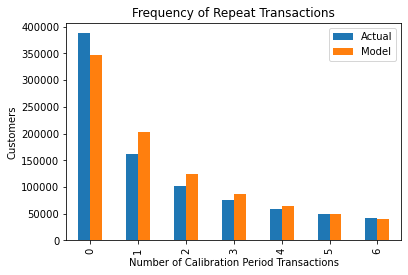

In [28]:
# training: does the model reflect the actual data closely enough?

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

<Figure size 504x504 with 0 Axes>

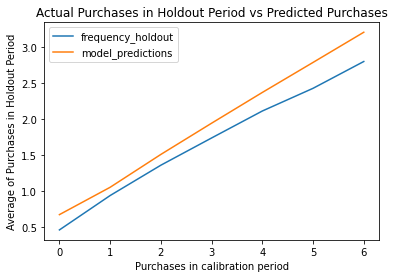

In [29]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch);

In [30]:
# determine recency, frequency, T, monetary value for each customer
df_rft = summary_data_from_transaction_data(
    transactions = data_grp, 
    customer_id_col = "customer_id", 
    datetime_col = "t_dat", 
    monetary_value_col = "price", 
    observation_period_end = max_date, 
    freq = "D")

pd.options.display.float_format = '{:,.0f}'.format
df_rft

,frequency,recency,T,monetary_value
customer_id,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,9,618,635,60
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,22,656,732,112
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,6,726,733,104
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0,0,471,0
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,5,670,711,80
...,...,...,...,...
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,10,522,538,78
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,18,693,728,97
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264,18,720,733,41


In [31]:
# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -9.070099
         Iterations: 26
         Function evaluations: 27
         Gradient evaluations: 27


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.548,0.001,0.546,0.549
alpha,45.800,0.096,45.611,45.989
a,0.115,0.001,0.113,0.116
b,1.699,0.019,1.663,1.736


426


<Figure size 864x864 with 0 Axes>

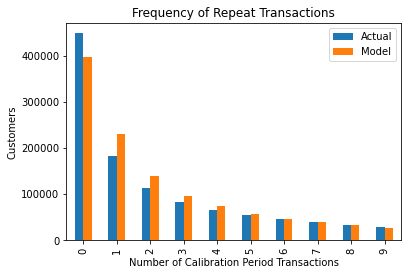

In [32]:
#axis length
max_freq = int(df_rft["frequency"].max())  #quantile(0.95))          
max_T = int(df_rft["T"].max())                         
max_rec = int(df_rft["recency"].max())  
print(max_freq)


# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,  
            max_frequency = 10);

C:\Users\zywon\Anaconda3\envs\py37\lib\site-packages\lifetimes\fitters\beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in double_scalars
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


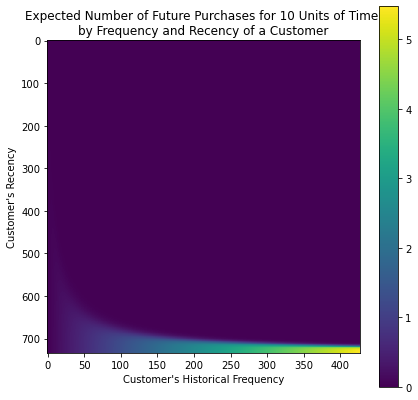

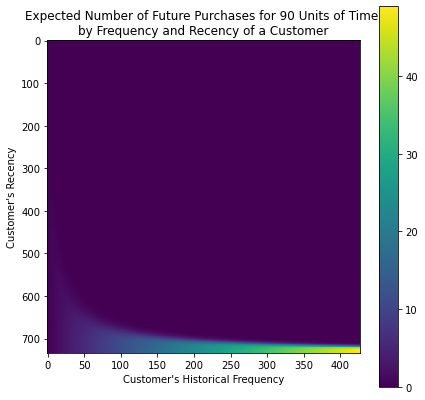

In [33]:

# helper function: plot expected number of future purchases a customer with 
#    frequency f and recency r will make in forecast period

def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7)) 
    plot_frequency_recency_matrix(
            model = bgf,   
            T = t,  
            max_frequency = max_freq,  
            max_recency = max_rec);
            
            
# call plotter function for different forecast periods:
tFC = [10, 90]
_ = [plot_freq_rec(t) for t in tFC]

In [34]:
# helper function: predict each customer's purchases over next t days
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])
                    
                    
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [10, 30, 60, 90]
_ = [predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rft

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
customer_id,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,9.0,618.0,635.0,59.9,0.1,0.4,0.8,1.2
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,22.0,656.0,732.0,112.5,0.3,0.8,1.6,2.5
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,6.0,726.0,733.0,103.9,0.1,0.2,0.5,0.7
00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2c5feb1ca5dff07c43e,0.0,0.0,471.0,0.0,0.0,0.0,0.1,0.1
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,5.0,670.0,711.0,80.4,0.1,0.2,0.4,0.6
...,...,...,...,...,...,...,...,...
ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e4747568cac33e8c541831,10.0,522.0,538.0,77.6,0.2,0.5,1.1,1.6
ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab53481233731b5c4f8b7,18.0,693.0,728.0,96.8,0.2,0.7,1.4,2.1
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264,18.0,720.0,733.0,41.5,0.2,0.7,1.4,2.1


In [35]:

# top 10 customers over next 30 days
print("top 10 customers, by their predicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
customer_id,,,,,,,,
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc,426.0,727.0,729.0,119.1,5.5,16.5,32.9,49.2
f137c16fd175271922dad4006565503952f24750a57388fe24970a218c62de6a,390.0,733.0,733.0,106.8,5.0,15.0,30.0,44.8
8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d659fa4e5c3af6cc076,389.0,727.0,732.0,101.9,5.0,14.9,29.8,44.6
788785852eddb5874f924603105f315d69571b3e5180f3a7ae6970b55b6d5dc9,321.0,733.0,733.0,92.7,4.1,12.4,24.7,36.9
e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffccd515dd5cef56126efb,317.0,729.0,730.0,68.7,4.1,12.2,24.4,36.6
03d0011487606c37c1b1ed147fc72f285a50c05f00b9712e0fc3da400c864296,293.0,727.0,733.0,170.0,3.8,11.2,22.4,33.6
be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b,292.0,725.0,732.0,197.2,3.7,11.2,22.3,33.5
7f6001be8053c5a9936622f5997e87319ca546b768979db6ff042c14f1bf7231,275.0,727.0,732.0,62.9,3.5,10.6,21.1,31.6
9ff538b9a79943aff0eeb492da5330595a57f696099a40afa66ff9f6beea63f3,271.0,725.0,732.0,103.3,3.5,10.4,20.8,31.1


CLV

In [36]:
# select customers with monetary value > 0
df_rftv = df_rft[df_rft["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
count,"914,308.00","914,308.00","914,308.00","914,308.00","914,308.00","914,308.00","914,308.00","914,308.00"
mean,8.44,407.34,567.49,94.24,0.13,0.38,0.75,1.12
std,10.81,232.43,179.38,78.38,0.14,0.43,0.86,1.29
min,1.00,1.00,1.00,0.85,0.00,0.00,0.00,0.00
25%,2.00,200.00,478.00,48.00,0.03,0.10,0.20,0.30
50%,5.00,446.00,644.00,72.15,0.08,0.24,0.49,0.73
75%,11.00,623.00,706.00,114.36,0.17,0.50,0.99,1.49
max,426.00,733.00,733.00,"5,624.00",5.50,16.47,32.86,49.19


In [37]:
# Gamma-Gamma model requires a Pearson correlation close to 0 
# between purchase frequency and monetary value

corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.023


In [38]:
# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 1e-06)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.298,0.012,3.274,3.322
q,3.532,0.006,3.519,3.544
v,73.561,0.355,72.865,74.257


In [39]:

# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rftv["frequency"],
        df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]

mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

MAPE of predicted revenues: 0.13


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
customer_id,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,9.000,618.000,635.000,59.874,0.138,0.413,0.825,1.235,62.700,59.874,2.826
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,22.000,656.000,732.000,112.494,0.276,0.825,1.647,2.466,111.932,112.494,-0.562
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,6.000,726.000,733.000,103.910,0.083,0.247,0.493,0.739,102.993,103.910,-0.916
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,5.000,670.000,711.000,80.386,0.071,0.214,0.426,0.638,82.442,80.386,2.056
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,2.000,468.000,476.000,61.831,0.047,0.140,0.279,0.417,71.261,61.831,9.430


In [40]:

# compute customer lifetime value
DISCOUNT_a = 0.06                # annual discount rate
LIFE = 12                        # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = df_rftv["frequency"],  
        recency = df_rftv["recency"],  
        T = df_rftv["T"],  
        monetary_value = df_rftv["monetary_value"],  
        time = LIFE,    
        freq = "D",                          
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)             # expected customer lifetime values
df_rftv.describe().T

,count,mean,std,min,25%,50%,75%,max
CLV,"914,308.000",406.434,603.628,0.000,89.462,217.582,482.485,"25,118.554"
frequency,"914,308.000",8.441,10.815,1.000,2.000,5.000,11.000,426.000
recency,"914,308.000",407.341,232.431,1.000,200.000,446.000,623.000,733.000
T,"914,308.000",567.488,179.376,1.000,478.000,644.000,706.000,733.000
monetary_value,"914,308.000",94.240,78.380,0.847,47.997,72.154,114.356,"5,624.000"
predict_purch_10,"914,308.000",0.126,0.145,0.000,0.034,0.081,0.167,5.497
predict_purch_30,"914,308.000",0.376,0.433,0.000,0.101,0.244,0.499,16.466
predict_purch_60,"914,308.000",0.750,0.863,0.000,0.202,0.486,0.995,32.863
predict_purch_90,"914,308.000",1.122,1.292,0.000,0.303,0.726,1.488,49.191
exp_avg_rev,"914,308.000",94.881,60.777,13.763,58.204,76.943,110.731,"3,223.334"


In [41]:
df_rftv.head(5)

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
customer_id,,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,294.708,9.000,618.000,635.000,59.874,0.138,0.413,0.825,1.235,62.700,59.874,2.826
0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,"1,052.650",22.000,656.000,732.000,112.494,0.276,0.825,1.647,2.466,111.932,112.494,-0.562
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,290.194,6.000,726.000,733.000,103.910,0.083,0.247,0.493,0.739,102.993,103.910,-0.916
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,200.619,5.000,670.000,711.000,80.386,0.071,0.214,0.426,0.638,82.442,80.386,2.056
0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a,112.778,2.000,468.000,476.000,61.831,0.047,0.140,0.279,0.417,71.261,61.831,9.430
